In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from copy import deepcopy
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras import layers, regularizers
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%store -r DF_INPUT_FILE
%store -r EMBEDDING_DIM
%store -r TOKENIZER_FILE
%store -r WORD2VEC_MATRIX_FILE
%store -r KERNEL_SIZE
%store -r MAXLEN
%store -r SENTENCE_GS_TRAIN_FILE
%store -r SENTENCE_GS_TEST_FILE
%store -r GS_TRAIN_FILE
%store -r GS_TEST_FILE
%store -r CLASS_TRAIN_FILE
%store -r CLASS_TEST_FILE
%store -r EPOCHS
%store -r GRID_SEARCH_BEST_MODEL_FILE
%store -r GRID_SEARCH_CV_RESULTS_FILE
%store -r GRID_SEARCH_FIG_FILE
%store -r VAL_DROPOUT
%store -r NUM_FILTERS
%store -r MODEL_CHECKPOINT_FILE
%store -r BATCH_SIZE
%store -r MODEL_STAT_FIG_FILE
%store -r MODEL_OP_FILE



In [3]:

with open(DF_INPUT_FILE, "rb") as fr:
    df = pickle.load(fr)

with open(TOKENIZER_FILE, "rb") as fr:
    tokenizer = pickle.load(fr)

with open(WORD2VEC_MATRIX_FILE, "rb") as fr:
    word2vec_matrix = pickle.load(fr)
    


In [6]:
def split_gs_class_for_train_test(df):

    gs = df['gs'].values
    class_num = df['cls'].values

    (
        sentence_gs_train, sentence_gs_test, class_train, class_test
    ) = train_test_split(
        gs, class_num, test_size=XXX, random_state=XXX
    )

    class_train = to_categorical(class_train - 1)
    class_test = to_categorical(class_test - 1)

    return sentence_gs_train, sentence_gs_test, class_train, class_test

In [7]:
def tokenize_data_set(
    tokenizer, sentence_gs_train, sentence_gs_test
):
    # TODO there is hyphen in string only like "-", the length would be 0
    gs_train = tokenizer.texts_to_sequences(sentence_gs_train)
    gs_test = tokenizer.texts_to_sequences(sentence_gs_test)

    # using following to stat and esti the length
    # sorted([len(item) for item in gs_test])[-10:]
    # sorted([len(item) for item in gs_train])[-10:]

    maxlen = max([len(item) for item in gs_train]) + KERNEL_SIZE - 1
    if maxlen < MAXLEN:
        print(
            f"the actual maxlen:{maxlen} is less than pre-setting MAXLEN:{MAXLEN}, "
            "using the acutal(smaller) one"
        )
    else:
        print(
            f"the actual maxlen:{maxlen} is large than pre-setting MAXLEN:{MAXLEN}, "
            f"the pre-setting:{MAXLEN} would be used, means some text in sample would be lose"
        )
        maxlen = MAXLEN
    gs_train = pad_sequences(gs_train, padding='post', maxlen=maxlen)
    gs_test = pad_sequences(gs_test, padding='post', maxlen=maxlen)


    return gs_train, gs_test, maxlen

In [10]:
def pickle_op_file(var, filename, base_dir=""):
    with open(
        os.path.join(base_dir, filename), "wb"
    ) as fw:
        pickle.dump(var, fw, protocol=4)

In [8]:
def prepare_train_test_set(
    tokenizer, df
):

    (
        sentence_gs_train, sentence_gs_test, class_train, class_test
    ) = split_gs_class_for_train_test(
        df
    )

    gs_train, gs_test, maxlen = tokenize_data_set(
        tokenizer, sentence_gs_train, sentence_gs_test
    )

    pickle_op_file(sentence_gs_train, SENTENCE_GS_TRAIN_FILE)
    pickle_op_file(sentence_gs_test, SENTENCE_GS_TEST_FILE)
    pickle_op_file(gs_train, GS_TRAIN_FILE)
    pickle_op_file(gs_test, GS_TEST_FILE)
    pickle_op_file(class_train, CLASS_TRAIN_FILE)
    pickle_op_file(class_test, CLASS_TEST_FILE)

    return gs_train, gs_test, class_train, class_test, maxlen

In [ ]:
(
    gs_train, gs_test, class_train, class_test, maxlen
) = prepare_train_test_set(
    tokenizer, df
)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
nonzero_elements = np.count_nonzero(
    np.count_nonzero(word2vec_matrix, axis=1)
)

print(
    f"vocab_size={vocab_size} and there are {nonzero_elements} words "
    f"in words_embedding, ratio={(nonzero_elements / vocab_size*100):.2f}%"
)

if gs_train.shape[1] != gs_test.shape[1]:
    print(
        f"the Y length of train:{gs_train.shape[1]} is "
        f"differnt with test:{gs_test.shape[1]}"
    )
    raise RuntimeError("the Y length of train is differnt with test")


In [69]:
# multiple filter layers model
def create_model_multi_conv(
    val_dropout, num_filters, kernel_sizes, vocab_size, embedding_dim, maxlen
):

    layer_inputs = layers.Input(shape=(maxlen, ), dtype='int32', name="input0")

    layer_embedding = layers.Embedding(
        vocab_size, embedding_dim,
        weights=[word2vec_matrix],
        input_length=maxlen,
        trainable=True,
        name="embedding"
    )(layer_inputs)

    layer_conv_0 = layers.Conv1D(
        num_filters, kernel_sizes[0], activation='relu', name='conv_0'
    )(layer_embedding)
    layer_conv_1 = layers.Conv1D(
        num_filters, kernel_sizes[1], activation='relu', name='conv_1'
    )(layer_embedding)
    layer_conv_2 = layers.Conv1D(
        num_filters, kernel_sizes[2], activation='relu', name='conv_2'
    )(layer_embedding)

    layer_conv_0 = layers.Dropout(val_dropout)(layer_conv_0)
    layer_conv_1 = layers.Dropout(val_dropout)(layer_conv_1)
    layer_conv_2 = layers.Dropout(val_dropout)(layer_conv_2)

    layer_maxpool_0 = layers.GlobalMaxPooling1D()(layer_conv_0)
    layer_maxpool_1 = layers.GlobalMaxPooling1D()(layer_conv_1)
    layer_maxpool_2 = layers.GlobalMaxPooling1D()(layer_conv_2)

    layer_concatenated_tensor = layers.Concatenate(axis=1)([
        layer_maxpool_0, layer_maxpool_1, layer_maxpool_2
    ])
    
    layer_flatten = layers.Flatten()(layer_concatenated_tensor)
    layer_dropout = layers.Dropout(val_dropout)(layer_flatten)
    
    layer_dense = layers.Dense(512, activation='relu')(layer_dropout)
    layer_dense = layers.Dense(256, activation='relu')(layer_dense)
    layer_dense = layers.Dense(45, activation='softmax')(layer_dense)
   
    model = Model(inputs=layer_inputs, outputs=layer_dense)
    
    model.compile(
        optimizer='adam',
        # optimizer=opt,
        # loss='binary_crossentropy',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        # metrics=['mse']
    )
    return model

## CNN model (fixed parameter)

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [13]:
#自建召回率计算函数，每一Epochs都进行F1计算
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def __init__(self, val_data, batch_size = 20):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 0:
            return
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict,average='weighted')
        _val_recall = recall_score(val_targ, val_predict,average='weighted')
        _val_precision = precision_score(val_targ, val_predict,average='weighted')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print( ' — val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return
    
metrics = Metrics(
    (gs_test, class_test), BATCH_SIZE
)

checkpoint = ModelCheckpoint(
    MODEL_CHECKPOINT_FILE,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)
earlyStopping=EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, mode='max')
callbacks_list = [checkpoint, earlyStopping, metrics]

In [ ]:
# model = create_model(
#     VAL_DROPOUT, NUM_FILTERS, KERNEL_SIZE,
#     vocab_size, EMBEDDING_DIM, maxlen
# )

model = create_model_multi_conv(
    VAL_DROPOUT, NUM_FILTERS, [2, 3, 4],
    vocab_size, EMBEDDING_DIM, maxlen
)

checkpoint = ModelCheckpoint(
    MODEL_CHECKPOINT_FILE,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=False,
    save_weights_only=False
)
earlyStopping=EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, mode='max')
callbacks_list = [checkpoint, earlyStopping, metrics]

history = model.fit(
    gs_train, class_train,
    epochs=EPOCHS,
    verbose=True,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    validation_data=(gs_test, class_test)
)

model.summary()
loss, accuracy = model.evaluate(gs_train, class_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model.evaluate(gs_test, class_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))
plot_history(history)
plt.savefig(MODEL_STAT_FIG_FILE)
model.save(MODEL_OP_FILE)

# CNN 调参

## 网格和随机网格调参

In [26]:
def plot_grid_search(
    cv_results, metric, grid_param_1, grid_param_2, name_param_1, name_param_2
):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results[('mean_test_' + metric)]
    scores_sd = cv_results[('std_test_' + metric)]

    if grid_param_2 is not None:
        scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
        scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Set plot style
    plt.style.use('seaborn')

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    if grid_param_2 is not None:
        # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
        for idx, val in enumerate(grid_param_2):
            ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    else:
        # If only one Param1 is given
        ax.plot(grid_param_1, scores_mean, '-o')

    ax.set_title("Grid Search", fontsize=20, fontweight='normal')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average ' + str.capitalize(metric), fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [ ]:
# Parameter grid for grid search
param_grid = dict(
    val_dropout=[0.3, 0.5, 0.7],
    num_filters=[64, 256, 512],
    kernel_size=[2, 5, 11, 15],
    vocab_size=[vocab_size],
    embedding_dim=[EMBEDDING_DIM],
    maxlen=[maxlen]
)

n_iter = 40

model = KerasClassifier(
    build_fn=create_model,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=True
)

grid = RandomizedSearchCV(
    estimator=model, param_distributions=param_grid,
    cv=4, verbose=1, n_iter=n_iter, n_jobs=-1
)

grid_result = grid.fit(gs_train, class_train)

# Evaluate testing set
test_accuracy = grid.score(gs_test, class_test)
print(f"test_accuracy={test_accuracy}")
print(f"best_score={grid_result.best_score_}")
print(f"best_params={grid_result.best_params_}")
grid.best_estimator_.model.save(
    GRID_SEARCH_BEST_MODEL_FILE
)

pickle_op_file(grid_result.cv_results_, GRID_SEARCH_CV_RESULTS_FILE)

actual_iters = grid_result.cv_results_["param_embedding_dim"].shape[0]
plot_grid_search(
    grid_result.cv_results_,
    'score',
    # list(range(1, n_iter+1, 1)),
    list(range(1, actual_iters+1, 1)),
    [list(range(1, 2, 1))],
    'iter',
    'score'
)

plt.savefig(GRID_SEARCH_FIG_FILE)

## 贝叶斯优化 Model 1.0
需要Keras Tuner + Python 3.6+ + TensorFlow 2.0+  
pip install keras-tuner

In [87]:
from keras_tuner import HyperParameters
import keras_tuner

In [ ]:
def create_model_multi_conv_1_0(hp):
    hp_padding = hp.Choice('padding_type', values=['valid', 'same'])
    hp_filters_num = hp.Choice('filters_num', values=[32, 64, 256, 512, 1024])
    hp_size = hp.Choice('kernal_sizes', values=[2, 3, 4])
    hp_val_dropout = hp.Choice('dropout', values=[0.3, 0.5, 0.7])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    opt = tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate,
        name="Adam"
    )

    layer_inputs = layers.Input(shape=(maxlen, ), dtype='int32', name="input0")

    layer_embedding = layers.Embedding(
        vocab_size, EMBEDDING_DIM,
        weights=[word2vec_matrix],
        input_length=maxlen,
        trainable=True,
        name="embedding"
    )(layer_inputs)

    layer_conv_0 = layers.Conv1D(
        hp_filters_num, hp_size - 1, activation='relu', padding=hp_padding, name='conv_0'
    )(layer_embedding)
    layer_conv_1 = layers.Conv1D(
        hp_filters_num, hp_size, activation='relu', padding=hp_padding, name='conv_1'
    )(layer_embedding)
    layer_conv_2 = layers.Conv1D(
        hp_filters_num, hp_size + 2, activation='relu', padding=hp_padding, name='conv_2'
    )(layer_embedding)

    layer_conv_0 = layers.Dropout(hp_val_dropout)(layer_conv_0)
    layer_conv_1 = layers.Dropout(hp_val_dropout)(layer_conv_1)
    layer_conv_2 = layers.Dropout(hp_val_dropout)(layer_conv_2)

    layer_maxpool_0 = layers.GlobalMaxPooling1D()(layer_conv_0)
    layer_maxpool_1 = layers.GlobalMaxPooling1D()(layer_conv_1)
    layer_maxpool_2 = layers.GlobalMaxPooling1D()(layer_conv_2)

    layer_concatenated_tensor = layers.Concatenate(axis=1)([
        layer_maxpool_0, layer_maxpool_1, layer_maxpool_2
    ])

    layer_flatten = layers.Flatten()(layer_concatenated_tensor)
    layer_dropout = layers.Dropout(hp_val_dropout)(layer_flatten)

    layer_dense = layers.Dense(512, activation='relu')(layer_dropout)
    layer_dense = layers.Dense(256, activation='relu')(layer_dense)
    layer_dense = layers.Dense(45, activation='softmax')(layer_dense)

    model = Model(inputs=layer_inputs, outputs=layer_dense)

    model.compile(
        # optimizer='adam',
        optimizer=opt,
        # loss='binary_crossentropy',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        # metrics=['mse']
    )

    return model

tuner_cnn = keras_tuner.tuners.BayesianOptimization(
    create_model_multi_conv,
    objective='val_loss',
    max_trials=30,
    directory='.',
    project_name='tuning-cnn'
)

tuner_cnn.search(
    gs_train,
    class_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(gs_test, class_test),
    callbacks=callbacks_list
)

best_mlp_hyperparameters = tuner_cnn.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
print(best_mlp_hyperparameters.values)

best_model = tuner_cnn.get_best_models()
best_model[0].summary()

"""
Best Hyper-parameters
{'padding_type': 'same', 'filters_num': 1024, 'kernal_sizes': 4, 'dropout': 0.3, 'learning_rate': 0.001}
"""



### tranin the model with best hyper-parameter

In [ ]:
best_model = tuner_cnn.hypermodel.build(best_mlp_hyperparameters)
history = best_model.fit(
    gs_train, class_train,
    epochs=EPOCHS,
    verbose=True,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    validation_data=(gs_test, class_test)
)

## 贝叶斯优化 Model 1.1

In [ ]:
from keras_tuner import HyperParameters
import keras_tuner

In [ ]:
def create_model_multi_conv_1_1(hp):
    hp_filters_num = hp.Choice('filters_num', values=[32, 64, 256, 512, 1024])
    hp_size = hp.Choice('kernal_sizes', values=[2, 3, 4])
    hp_val_dropout = hp.Choice('dropout', values=[0.3, 0.5, 0.7])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    opt = tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate,
        name="Adam"
    )

    layer_inputs = layers.Input(shape=(maxlen, ), dtype='int32', name="input0")

    layer_embedding = layers.Embedding(
        vocab_size, EMBEDDING_DIM,
        weights=[word2vec_matrix],
        input_length=maxlen,
        trainable=True,
        name="embedding"
    )(layer_inputs)

    layer_conv_0 = layers.Conv1D(
        hp_filters_num, hp_size - 1, activation='relu', padding='same', name='conv_0'
    )(layer_embedding)
    layer_conv_1 = layers.Conv1D(
        hp_filters_num, hp_size, activation='relu', padding='same', name='conv_1'
    )(layer_embedding)
    layer_conv_2 = layers.Conv1D(
        hp_filters_num, hp_size + 1, activation='relu', padding='same', name='conv_2'
    )(layer_embedding)

    layer_conv_0 = layers.Dropout(hp_val_dropout)(layer_conv_0)
    layer_conv_1 = layers.Dropout(hp_val_dropout)(layer_conv_1)
    layer_conv_2 = layers.Dropout(hp_val_dropout)(layer_conv_2)

    layer_maxpool_0 = layers.GlobalMaxPooling1D()(layer_conv_0)
    layer_maxpool_1 = layers.GlobalMaxPooling1D()(layer_conv_1)
    layer_maxpool_2 = layers.GlobalMaxPooling1D()(layer_conv_2)

    layer_concatenated_tensor = layers.Concatenate(axis=1)([
        layer_maxpool_0, layer_maxpool_1, layer_maxpool_2
    ])

    layer_flatten = layers.Flatten()(layer_concatenated_tensor)
    layer_dropout = layers.Dropout(hp_val_dropout)(layer_flatten)

    layer_dense = layers.Dense(45, activation='softmax')(layer_dropout)

    model = Model(inputs=layer_inputs, outputs=layer_dense)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner_cnn = keras_tuner.tuners.BayesianOptimization(
    create_model_multi_conv,
    objective='val_loss',
    max_trials=50,
    directory='.',
    project_name='tuning-cnn'
)

tuner_cnn.search(
    gs_train,
    class_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(gs_test, class_test),
    callbacks=callbacks_list
)

best_mlp_hyperparameters = tuner_cnn.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
print(best_mlp_hyperparameters.values)

best_model = tuner_cnn.get_best_models()
best_model[0].summary()

"""
Best Hyper-parameters
{'padding_type': 'same', 'filters_num': 1024, 'kernal_sizes': 4, 'dropout': 0.3, 'learning_rate': 0.001}
"""



### tranin the model with best hyper-parameter

In [ ]:
best_model = tuner_cnn.hypermodel.build(best_mlp_hyperparameters)
history = best_model.fit(
    gs_train, class_train,
    epochs=EPOCHS,
    verbose=True,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    validation_data=(gs_test, class_test)
)

## 固定参数的model（from 贝叶斯优化的结果）

In [15]:
def create_model_multi_conv_1_1():
    
    opt = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        name="Adam"
    )

    layer_inputs = layers.Input(shape=(maxlen, ), dtype='int32', name="input0")

    layer_embedding = layers.Embedding(
        vocab_size, EMBEDDING_DIM,
        weights=[word2vec_matrix],
        input_length=maxlen,
        trainable=True,
        name="embedding"
    )(layer_inputs)

    layer_conv_0 = layers.Conv1D(
        512, 3, activation='relu', padding='same', name='conv_0', kernel_regularizer=regularizers.l2(0.0015)
    )(layer_embedding)
    layer_conv_1 = layers.Conv1D(
        512, 4, activation='relu', padding='same', name='conv_1', kernel_regularizer=regularizers.l2(0.0015)
    )(layer_embedding)
    layer_conv_2 = layers.Conv1D(
        512, 5, activation='relu', padding='same', name='conv_2', kernel_regularizer=regularizers.l2(0.0015)
    )(layer_embedding)

    layer_conv_0 = layers.Dropout(0.5)(layer_conv_0)
    layer_conv_1 = layers.Dropout(0.5)(layer_conv_1)
    layer_conv_2 = layers.Dropout(0.5)(layer_conv_2)

    layer_maxpool_0 = layers.GlobalMaxPooling1D()(layer_conv_0)
    layer_maxpool_1 = layers.GlobalMaxPooling1D()(layer_conv_1)
    layer_maxpool_2 = layers.GlobalMaxPooling1D()(layer_conv_2)

    layer_concatenated_tensor = layers.Concatenate(axis=1)([
        layer_maxpool_0, layer_maxpool_1, layer_maxpool_2
    ])

    layer_flatten = layers.Flatten()(layer_concatenated_tensor)
    layer_dropout = layers.Dropout(0.5)(layer_flatten)

    layer_dense = layers.Dense(512, activation='relu')(layer_dropout)
    layer_dropout = layers.Dropout(0.5)(layer_dense)
    layer_dense = layers.Dense(256, activation='relu')(layer_dropout)
    layer_dropout = layers.Dropout(0.5)(layer_dense)
    layer_dense = layers.Dense(45, activation='softmax')(layer_dropout)

    model = Model(inputs=layer_inputs, outputs=layer_dense)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-30 10:42:11.539604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-30 10:42:11.539757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2022-12-30 10:42:11.825065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-30 10:42:12.250677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


688/688 [==============================] - ETA: 0s - loss: 2.7644 - accuracy: 0.4604

2022-12-30 10:42:54.784293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.64144, saving model to training/us_01/cnn_model-01-0.64.hdf5
688/688 [==============================] - 50s 70ms/step - loss: 2.7644 - accuracy: 0.4604 - val_loss: 2.2603 - val_accuracy: 0.6414
Epoch 2/30
688/688 [==============================] - ETA: 0s - loss: 1.5795 - accuracy: 0.7110
Epoch 2: val_accuracy improved from 0.64144 to 0.72278, saving model to training/us_01/cnn_model-02-0.72.hdf5
 11/282 [>.............................] - ETA: 3s

2022-12-30 10:43:48.472514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - 4s 12ms/step
 — val_f1: 0.312462 — val_precision: 0.823469 — val_recall 0.229667
688/688 [==============================] - 50s 73ms/step - loss: 1.5795 - accuracy: 0.7110 - val_loss: 2.0935 - val_accuracy: 0.7228
Epoch 3/30
  2/688 [..............................] - ETA: 44s - loss: 1.0959 - accuracy: 0.8438 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


688/688 [==============================] - ETA: 0s - loss: 1.2061 - accuracy: 0.8078
Epoch 3: val_accuracy improved from 0.72278 to 0.74178, saving model to training/us_01/cnn_model-03-0.74.hdf5
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.515110 — val_precision: 0.834157 — val_recall 0.409111
688/688 [==============================] - 50s 73ms/step - loss: 1.2061 - accuracy: 0.8078 - val_loss: 1.8145 - val_accuracy: 0.7418
Epoch 4/30
  2/688 [..............................] - ETA: 41s - loss: 1.2006 - accuracy: 0.8125 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


687/688 [============================>.] - ETA: 0s - loss: 1.0215 - accuracy: 0.8523
Epoch 4: val_accuracy improved from 0.74178 to 0.74822, saving model to training/us_01/cnn_model-04-0.75.hdf5
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.532527 — val_precision: 0.870858 — val_recall 0.420444
688/688 [==============================] - 50s 73ms/step - loss: 1.0224 - accuracy: 0.8522 - val_loss: 1.7104 - val_accuracy: 0.7482
Epoch 5/30
  2/688 [..............................] - ETA: 45s - loss: 0.8193 - accuracy: 0.9375 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


688/688 [==============================] - ETA: 0s - loss: 0.8659 - accuracy: 0.8813
Epoch 5: val_accuracy did not improve from 0.74822
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.599876 — val_precision: 0.888522 — val_recall 0.481000
688/688 [==============================] - 49s 71ms/step - loss: 0.8659 - accuracy: 0.8813 - val_loss: 1.6540 - val_accuracy: 0.7411
Epoch 6/30
  2/688 [..............................] - ETA: 47s - loss: 0.6362 - accuracy: 0.9688

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


688/688 [==============================] - ETA: 0s - loss: 0.8342 - accuracy: 0.8963
Epoch 6: val_accuracy did not improve from 0.74822
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.606477 — val_precision: 0.873422 — val_recall 0.491111
688/688 [==============================] - 48s 70ms/step - loss: 0.8342 - accuracy: 0.8963 - val_loss: 1.6307 - val_accuracy: 0.7429
Epoch 7/30
  2/688 [..............................] - ETA: 49s - loss: 0.6489 - accuracy: 0.9688 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


688/688 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.9153
Epoch 7: val_accuracy did not improve from 0.74822
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.643557 — val_precision: 0.880054 — val_recall 0.526778
688/688 [==============================] - 47s 69ms/step - loss: 0.7365 - accuracy: 0.9153 - val_loss: 1.5531 - val_accuracy: 0.7444
Epoch 8/30
  2/688 [..............................] - ETA: 52s - loss: 0.6950 - accuracy: 0.9062 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


687/688 [============================>.] - ETA: 0s - loss: 0.7166 - accuracy: 0.9195
Epoch 8: val_accuracy improved from 0.74822 to 0.75400, saving model to training/us_01/cnn_model-08-0.75.hdf5
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.675800 — val_precision: 0.889002 — val_recall 0.569000
688/688 [==============================] - 47s 69ms/step - loss: 0.7168 - accuracy: 0.9195 - val_loss: 1.4967 - val_accuracy: 0.7540
Epoch 9/30
  2/688 [..............................] - ETA: 37s - loss: 0.4821 - accuracy: 1.0000 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


687/688 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.9304
Epoch 9: val_accuracy did not improve from 0.75400
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.673361 — val_precision: 0.868802 — val_recall 0.577667
688/688 [==============================] - 47s 69ms/step - loss: 0.6521 - accuracy: 0.9302 - val_loss: 1.4802 - val_accuracy: 0.7369
Epoch 10/30
  3/688 [..............................] - ETA: 35s - loss: 0.5569 - accuracy: 0.9375

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


687/688 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.9255
Epoch 10: val_accuracy did not improve from 0.75400
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.672768 — val_precision: 0.860650 — val_recall 0.575000
688/688 [==============================] - 46s 67ms/step - loss: 0.6787 - accuracy: 0.9255 - val_loss: 1.5002 - val_accuracy: 0.7373
Epoch 11/30
  2/688 [..............................] - ETA: 35s - loss: 0.4533 - accuracy: 1.0000 

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


688/688 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.9365
Epoch 11: val_accuracy did not improve from 0.75400
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.665726 — val_precision: 0.877476 — val_recall 0.558778
688/688 [==============================] - 47s 68ms/step - loss: 0.6020 - accuracy: 0.9365 - val_loss: 1.5275 - val_accuracy: 0.7308
Epoch 12/30
  3/688 [..............................] - ETA: 35s - loss: 0.6111 - accuracy: 0.9167

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


687/688 [============================>.] - ETA: 0s - loss: 0.6375 - accuracy: 0.9355
Epoch 12: val_accuracy did not improve from 0.75400
282/282 [==============================] - 3s 12ms/step
 — val_f1: 0.690429 — val_precision: 0.867997 — val_recall 0.592778
688/688 [==============================] - 46s 67ms/step - loss: 0.6375 - accuracy: 0.9355 - val_loss: 1.4937 - val_accuracy: 0.7381
Epoch 12: early stopping
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input0 (InputLayer)            [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     27180300    ['input0[0][0]']                 
                                                                       

/Users/vincentcheng/miniforge3/envs/tm_nlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.9739
Training Loss: 0.7036
Testing Accuracy:  0.7381
Testing Loss:  1.4937


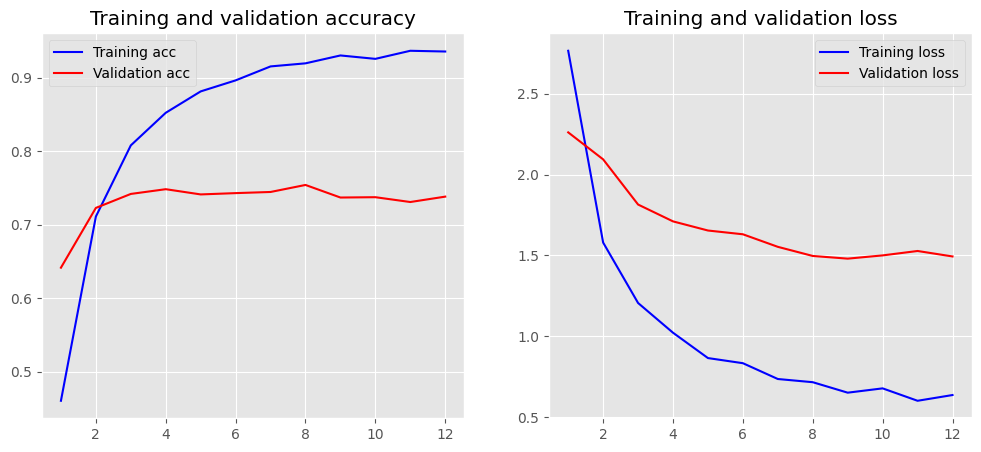

In [16]:
model = create_model_multi_conv_1_1()
# model = create_model(0.5, 256, 3, 90601, 300, 100)

history = model.fit(
    gs_train, class_train,
    epochs=EPOCHS,
    verbose=True,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    validation_data=(gs_test, class_test),
    shuffle=True,
)

model.summary()
loss, accuracy = model.evaluate(gs_train, class_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model.evaluate(gs_test, class_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))
plot_history(history)
plt.savefig(MODEL_STAT_FIG_FILE)
model.save(MODEL_OP_FILE)

# Temporary Code

In [5]:
np.count_nonzero(
    np.count_nonzero(word2vec_matrix, axis=1)
)


34149

In [7]:
word2vec_matrix.shape

(90601, 300)